In [1]:
import json
import cv2
from matplotlib import pyplot as plt
import numpy as np
from IPython.display import Markdown as md
import math

In [2]:
file = open("alphapose-results.json", 'r')
content  = file.read()
deser = json.loads(content)

In [3]:
def project_velo_to_cam2(calib):
    P_velo2cam_ref = np.vstack((calib['Tr_velo_to_cam'].reshape(3, 4), np.array([0., 0., 0., 1.])))  # velo2ref_cam
    R_ref2rect = np.eye(4)
    R0_rect = calib['R0_rect'].reshape(3, 3)  # ref_cam2rect
    R_ref2rect[:3, :3] = R0_rect
    P_rect2cam2 = calib['P2'].reshape((3, 4))
    proj_mat = P_rect2cam2 @ R_ref2rect @ P_velo2cam_ref
    return proj_mat

In [4]:
def project_to_image(points, proj_mat):
    """
    Apply the perspective projection
    Args:
        pts_3d:     3D points in camera coordinate [3, npoints]
        proj_mat:   Projection matrix [3, 4]
    """
    num_pts = points.shape[1]

    # Change to homogenous coordinate
    points = np.vstack((points, np.ones((1, num_pts))))
    points = proj_mat @ points
    points[:2, :] /= points[2, :]
    return points[:2, :]

In [5]:
def render_lidar_on_image(pts_velo, img, calib, img_width, img_height):
    # projection matrix (project from velo2cam2)
    proj_velo2cam2 = project_velo_to_cam2(calib)

    # apply projection
    pts_2d = project_to_image(pts_velo.transpose(), proj_velo2cam2)

    # Filter lidar points to be within image FOV
    inds = np.where((pts_2d[0, :] < img_width) & (pts_2d[0, :] >= 0) &
                    (pts_2d[1, :] < img_height) & (pts_2d[1, :] >= 0) &
                    (pts_velo[:, 0] > 0)
                    )[0]
    print(pts_2d.shape, pts_velo.shape)

    # Filter out pixels points
    imgfov_pc_pixel = pts_2d[:, inds]
    print(type(imgfov_pc_pixel), imgfov_pc_pixel.shape)

    # Retrieve depth from lidar
    imgfov_pc_velo = pts_velo[inds, :]
    imgfov_pc_velo = np.hstack((imgfov_pc_velo, np.ones((imgfov_pc_velo.shape[0], 1))))
    imgfov_pc_cam2 = proj_velo2cam2 @ imgfov_pc_velo.transpose()

    cmap = plt.cm.get_cmap('hsv', 256)
    cmap = np.array([cmap(i) for i in range(256)])[:, :3] * 255

    for i in range(imgfov_pc_pixel.shape[1]):
        depth = imgfov_pc_cam2[2, i]
        color = cmap[min(int(640.0 / depth),255), :]
        cv2.circle(img, (int(np.round(imgfov_pc_pixel[0, i])),
                         int(np.round(imgfov_pc_pixel[1, i]))),
                   1, color=tuple(color), thickness=-1)
    plt.imshow(img)
#     plt.yticks([])
#     plt.xticks([])
    plt.show()
    return img

In [14]:
def read_calib_file(filepath):
    """
    Read in a calibration file and parse into a dictionary.
    Ref: https://github.com/utiasSTARS/pykitti/blob/master/pykitti/utils.py
    """
    data = {}
    with open(filepath, 'r') as f:
        for line in f.readlines():
            line = line.rstrip()
            if len(line) == 0: continue
            key, value = line.split(':', 1)
            # The only non-float values in these files are dates, which
            # we don't care about anyway
            try:
                data[key] = np.array([float(x) for x in value.split()])
            except ValueError:
                pass

    return data

In [16]:
def load_velo_scan(velo_filename):
    scan = np.fromfile(velo_filename, dtype=np.float32)
    scan = scan.reshape((-1, 4))
    return scan

In [17]:
calib = read_calib_file('/home/eam/KittiDs/data_tracking_calib/training/calib/0017.txt')
pc_velo = load_velo_scan('/home/eam/KittiDs/data_tracking_velodyne/training/velodyne/0017/000024.bin')[:, :3]

In [36]:
def reject_outliers(data, m = 2.):
    """ Reject outliers from distance meaurement
    """
    depths= data[2,:]
    d = np.abs(depths - np.median(depths))
    mdev = np.median(d)
    s = d/mdev if mdev else 0.
    return data[:, s<m]

In [27]:
def find_non_anomalies(input_data):
    #define a list to accumlate anomalies
    non_anomalies = np.empty(shape=(3,0))
    data = input_data[2,:]
    
    # Set upper and lower limit to 3 standard deviation
    data_std = np.std(data)
    data_mean = np.mean(data)
    anomaly_cut_off = data_std * 3
    
    lower_limit  = data_mean - anomaly_cut_off 
    upper_limit = data_mean + anomaly_cut_off
    #print(lower_limit)
    # Generate outliers
    for outlier_idx in range(input_data.shape[1]):
        if input_data[2, outlier_idx] <= upper_limit or input_data[2, outlier_idx] >= lower_limit:
            non_anomalies = np.hstack((non_anomalies, input_data))
    return non_anomalies

In [40]:
def project_to_bbox(pts_velo, img, calib, img_width, img_height, detctions):
    # projection matrix (project from velo2cam2)
    proj_velo2cam2 = project_velo_to_cam2(calib)

    # apply projection
    pts_2d = project_to_image(pts_velo.transpose(), proj_velo2cam2)

    # Filter lidar points to be within image FOV
    inds = np.where((pts_2d[0, :] < img_width) & (pts_2d[0, :] >= 0) &
                    (pts_2d[1, :] < img_height) & (pts_2d[1, :] >= 0) &
                    (pc_velo[:, 0] > 0)
                    )[0]

    # Filter out pixels points
    imgfov_pc_pixel = pts_2d[:, inds]

    # Retrieve depth from lidar
    imgfov_pc_velo = pts_velo[inds, :]
    imgfov_pc_velo = np.hstack((imgfov_pc_velo, np.ones((imgfov_pc_velo.shape[0], 1))))
    imgfov_pc_cam2 = proj_velo2cam2 @ imgfov_pc_velo.transpose()

    cmap = plt.cm.get_cmap('hsv', 256)
    cmap = np.array([cmap(i) for i in range(256)])[:, :3] * 255
    
    cnt_lidars = []
    for point in detctions:
        
        
        upper_left = point[0]
        lower_right = point[1]
        
        
        box_indices = np.where((imgfov_pc_pixel[0, :] > upper_left[0]) & (imgfov_pc_pixel[0, :] < lower_right[0])&
                              (imgfov_pc_pixel[1, :] > upper_left[1])&(imgfov_pc_pixel[1, :] < lower_right[1]))[0]
        
        projected_points = imgfov_pc_pixel[:, box_indices]
        cnt_lidar = 0
        lidar_points = np.empty(shape=(3,0))
        for i in range(projected_points.shape[1]):
            depth = imgfov_pc_cam2[2, i]
            color = cmap[min(int(640.0 / depth),255), :]
            
            cv2.circle(img, (int(np.round(projected_points[0, i])),
                             int(np.round(projected_points[1, i]))),
                       2, color=(100,100,100), thickness=-1)
#             print(lidar_points.shape, projected_points[:,i].shape)
            lidar_points = np.hstack((lidar_points, np.array([*projected_points[:,i], depth]).reshape(3,1)))
            cnt_lidar += 1
            
        refined = reject_outliers(lidar_points,0.4)
        for refined_idx in range(refined.shape[1]):
            cv2.circle(img, (int(np.round(refined[0, refined_idx])),
                             int(np.round(refined[1, refined_idx]))),
                       2, color=(0,0,255), thickness=-1)
            
        cnt_lidars.append(cnt_lidar)
        
        
        
        
#         cnt_lidar = 0
#         for i in range(imgfov_pc_pixel.shape[1]):
#             if imgfov_pc_pixel[0, i] > upper_left[0] and imgfov_pc_pixel[0, i] < lower_right[0] and\
#                 imgfov_pc_pixel[1, i] > upper_left[1] and imgfov_pc_pixel[1, i] < lower_right[1]: 
#                 depth = imgfov_pc_cam2[2, i]
#                 color = cmap[min(int(640.0 / depth),255), :]
#                 cv2.circle(img, (int(np.round(imgfov_pc_pixel[0, i])),
#                                  int(np.round(imgfov_pc_pixel[1, i]))),
#                            2, color=(100,100,100), thickness=-1)
#                 cnt_lidar += 1
#         cnt_lidars.append(cnt_lidar)
    
#     plt.imshow(img)
#     plt.show()
    return img, cnt_lidars

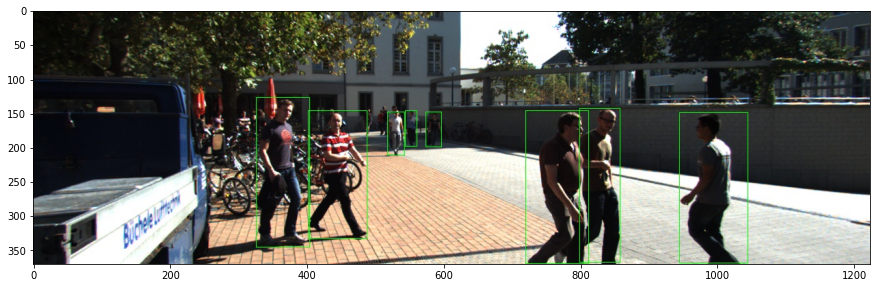

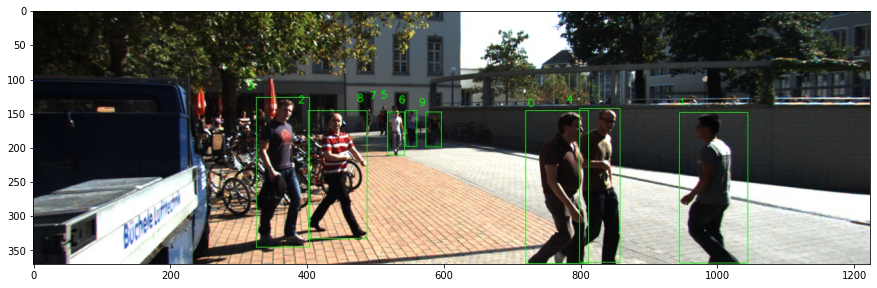

In [33]:
img5 = cv2.imread('prediction-yolov3.jpg')
img_height, img_width, img_channel = img5.shape
img5 = cv2.cvtColor(img5, cv2.COLOR_BGR2RGB)
plt.rcParams["figure.figsize"] = (15,8)
plt.imshow(img5)
plt.show()

detctions = [[[733,150],[822,366]],
             [[954,149],[1032,369]],
             [[397,145],[487,328]],
             [[322,125],[404,336]],
             [[790,144],[865,361]],
             [[518,138],[540,213]],
             [[544,145],[565,198]],
             [[502,139],[517,183]],
             [[483,143],[497,181]],
             [[574,149],[596,199]]]

cnt = 0
bbox_cnt = img5.copy()
for point in detctions:
    upper_left = point[0]
    lower_right = point[1]
    
    bbox_cnt = cv2.putText(bbox_cnt, f'{cnt}', (upper_left[0]-10,upper_left[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 
                   0.5, (0,255,0), 1, cv2.LINE_AA)
    cnt +=1

plt.imshow(bbox_cnt)
plt.show()

In [41]:
%%time
bbox_projected, bbox_cnt_lidars = project_to_bbox(pc_velo, img5.copy(), calib, img_width, img_height, detctions)

CPU times: user 1.12 s, sys: 27.2 ms, total: 1.15 s
Wall time: 194 ms


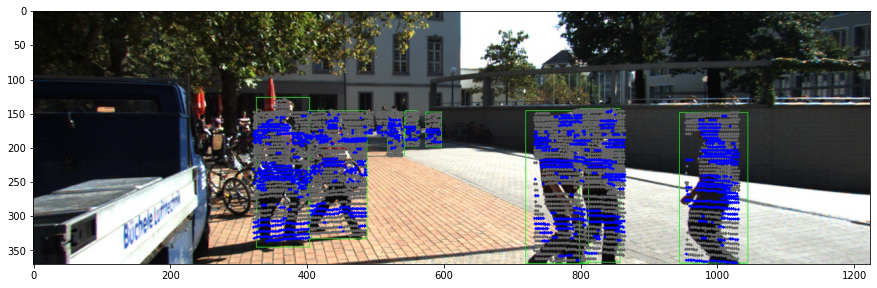

In [42]:
plt.imshow(bbox_projected)
plt.show()

In [44]:
bbox_projected_bgr = cv2.cvtColor(bbox_projected, cv2.COLOR_RGB2BGR)
cv2.imwrite("bbox_projected_outlier.jpg", bbox_projected_bgr)

True